In [46]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments


In [48]:
from pdf2image import convert_from_path
import os
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import AzureChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
)
from dotenv import load_dotenv, find_dotenv
import base64
import requests
import json
from datetime import datetime
from langchain.schema import Document
import re
import shutil
from joblib import Parallel, delayed
from functools import partial
import pickle
from IPython.display import Image, display
from langchain_core.runnables import RunnableLambda
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
import asyncio
import nest_asyncio
from glob import glob

In [49]:
load_dotenv(find_dotenv("dev.env"))

True

##### __Modular Functions__

In [50]:
def convert_pdf_to_images(pdf_path, dest_folder, image_format="JPEG"):
    """
    Converts each page of a PDF into images and saves them in a directory.

    Args:
    - pdf_path (str): Path to the PDF file.
    - dest_folder (str): Destination folder to save the images.
    - image_format (str): Format to save the images (default is "JPEG").

    Returns:
    - list: List of image file paths saved.
    """

    file_name = pdf_path.split("/")[-1].split(".")[0]
    file_version = pdf_path.split("/")[-2]
    contractor_name = pdf_path.split("/")[-3]

    pdf_name = f"{contractor_name}__{file_version}__{file_name}"
    output_dir = os.path.join(dest_folder, f"{pdf_name}_images")
    if os.path.exists(output_dir):
        # remove the existing directory
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    images = convert_from_path(pdf_path)
    saved_image_paths = []

    for i, img in enumerate(images):
        image_path = os.path.join(output_dir, f"page{i}.{image_format.lower()}")
        img.save(image_path, image_format)
        saved_image_paths.append(image_path)

    return saved_image_paths

In [51]:
def get_encode_image(image_path):
    """
    Encodes an image to base64 utf-8 string.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - str: Base64 encoded string of the image.
    """
    with open(image_path, "rb") as img_file:
        encoded_image = base64.b64encode(img_file.read()).decode("utf-8")
    return encoded_image

In [52]:
def get_gpt_model(
    azure_deployment,
    model_name,
    api_key,
    azure_endpoint,
    openai_api_type,
    api_version,
    temperature,
    request_timeout,
    max_retries,
    seed,
    top_p,
):
    """
    Returns an instance of the AzureChatOpenAI class.

    Args:
    - azure_deployment (str): Azure deployment name.
    - model_name (str): Name of the model.
    - api_key (str): API key.
    - azure_endpoint (str): Azure endpoint.
    - openai_api_type (str): OpenAI API type.
    - api_version (str): API version.
    - temperature (float): Temperature for sampling.
    - request_timeout (int): Request timeout.
    - max_retries (int): Maximum number of retries.
    - seed (int): Seed for random number generator.
    - top_p (float): Top-p sampling.

    Returns:
    - AzureChatOpenAI: Instance of the AzureChatOpenAI class.
    """

    llm_model = llm = AzureChatOpenAI(
        azure_deployment=azure_deployment,
        model_name=model_name,
        api_key=api_key,
        azure_endpoint=azure_endpoint,
        openai_api_type=openai_api_type,
        api_version=api_version,
        temperature=temperature,
        request_timeout=request_timeout,
        max_retries=max_retries,
        seed=seed,
        top_p=top_p,
    )

    return llm_model

In [53]:
def get_prompt(system_message):
    """
    Returns a ChatPromptTemplate instance with an image and system message.

    Args:
    - system_message (str): System message to display.

    Returns:
    - ChatPromptTemplate: Instance of the ChatPromptTemplate class.

    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            (
                "user",
                [
                    {
                        "type": "text",
                        "text": "Extract all the text from the image while considering most optimal ways to extract text out of tables and figures",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
                    },
                ],
            ),
        ]
    )
    return prompt

In [54]:
async def get_op_parser(response):
    """
    Returns the output parser for the response.

    Args:
    - response (str): Response from the model.

    Returns:
    - JsonOutputParser: Instance of the JsonOutputParser class.
    """
    response_op = response.dict()
    pg_content = response_op["content"]
    token_size = response_op["usage_metadata"]["output_tokens"]

    return json.dumps({"pg_content": pg_content, "token_size": token_size})

In [55]:
class ImageInformation(BaseModel):
    """Information extracted from the image in the form of free text."""

    pg_content: str = Field(
        description="Entire text extracted out of the image by the AI agent"
    )
    token_size: int = Field(
        description="Number of tokens recorded for the output text")


final_parser = JsonOutputParser(pydantic_object=ImageInformation)

In [56]:
async def image_to_text_chain(system_message: str, encoded_image: bytes, llm_model):
    """
    Extracts information from an image containing text, tables, and figures.

    Args:
    - system_message (str): System message to display.
    - encoded_image (bytes): Base64 encoded image.
    - llm_model (AzureChatOpenAI): Instance of the AzureChatOpenAI class.

    Returns:
    - ImageInformation: Information extracted from the image in the form of free text.
    """
    prompt = get_prompt(system_message)
    chain = prompt | llm_model | RunnableLambda(
        func=get_op_parser) | final_parser
    response_op = await chain.ainvoke({"image_data": encoded_image})
    return response_op

In [57]:
async def get_lc_document_from_response(response, image_path):
    """
    Creates a LangChain Document object from the GPT model's response.

    Args:
    - response (dict): Response from the GPT model.
    - image_path (str): Path to the image file.

    Returns:
    - Document: LangChain Document object containing extracted content and metadata.
    """
    curr_time = datetime.now()
    whole_pdf_name = re.findall(r"(.*)_images\b", image_path.split("/")[-2])[0]
    file_name = whole_pdf_name.split("__")[-1].split(".")[0]
    file_version = whole_pdf_name.split("__")[-2]
    contractor_name = whole_pdf_name.split("__")[-3]
    page_num = re.findall(r"page(\d+).jpeg", image_path.split("/")[-1])[0]

    # langchain document object

    doc = Document(
        page_content=response["pg_content"],
        metadata={
            "source": whole_pdf_name,
            "file_name":file_name,
            "file_version": file_version,
            "contractor_name": contractor_name,
            "page_number": int(page_num),
            "token_size": response["token_size"],
            "timestamp": str(curr_time),
        },
    )

    return doc

In [58]:
async def final_image_extraction_pipeline(image_path, system_message, llm_model):
    """
    Extracts information from an image containing text, tables, and figures.

    Args:
    - image_path (str): Path to the image file.
    - system_message (str): System message to display.
    - llm_model (AzureChatOpenAI): Instance of the AzureChatOpenAI class.

    Returns:
    - Document: LangChain Document object containing extracted content and metadata
    """
    encoded_image = get_encode_image(image_path)
    response_op = await image_to_text_chain(system_message, encoded_image, llm_model)
    lc_doc = await get_lc_document_from_response(response_op, image_path)
    return lc_doc

Execution Mode

In [59]:
root_folder = os.path.join(os.getcwd(), "contracts/Accenture")
pdf_files = glob(os.path.join(root_folder,"**" ,"*.pdf"), recursive=True)

In [60]:
file_a = pdf_files[0]
print(file_a)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments/contracts/Accenture/Original/MSA Completely Signed Accenture.pdf


In [61]:
saved_paths = convert_pdf_to_images(file_a, "image_extracts")
print("Images saved to:", saved_paths)

Images saved to: ['image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page0.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page1.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page2.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page3.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page4.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page5.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page6.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page7.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page8.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page9.jpeg', 'image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page10.jpeg', 'i

In [62]:
# adding paths to each image file
img_folder_names = os.listdir("image_extracts")
print(img_folder_names)
file_name = img_folder_names[-2]

['1. MSA Gateware (Enteron) 1_images', 'Accenture__Original__MSA Completely Signed Accenture_images', 'sample']


In [63]:
docs_ls = os.listdir(f"image_extracts/{file_name}")
docs_ls = [os.path.join(
    f"image_extracts/{file_name}", doc) for doc in docs_ls]
print(len(docs_ls))

99


In [64]:
import random

In [65]:
image_path = docs_ls[random.randint(0, len(docs_ls))]
print(image_path)

image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page29.jpeg


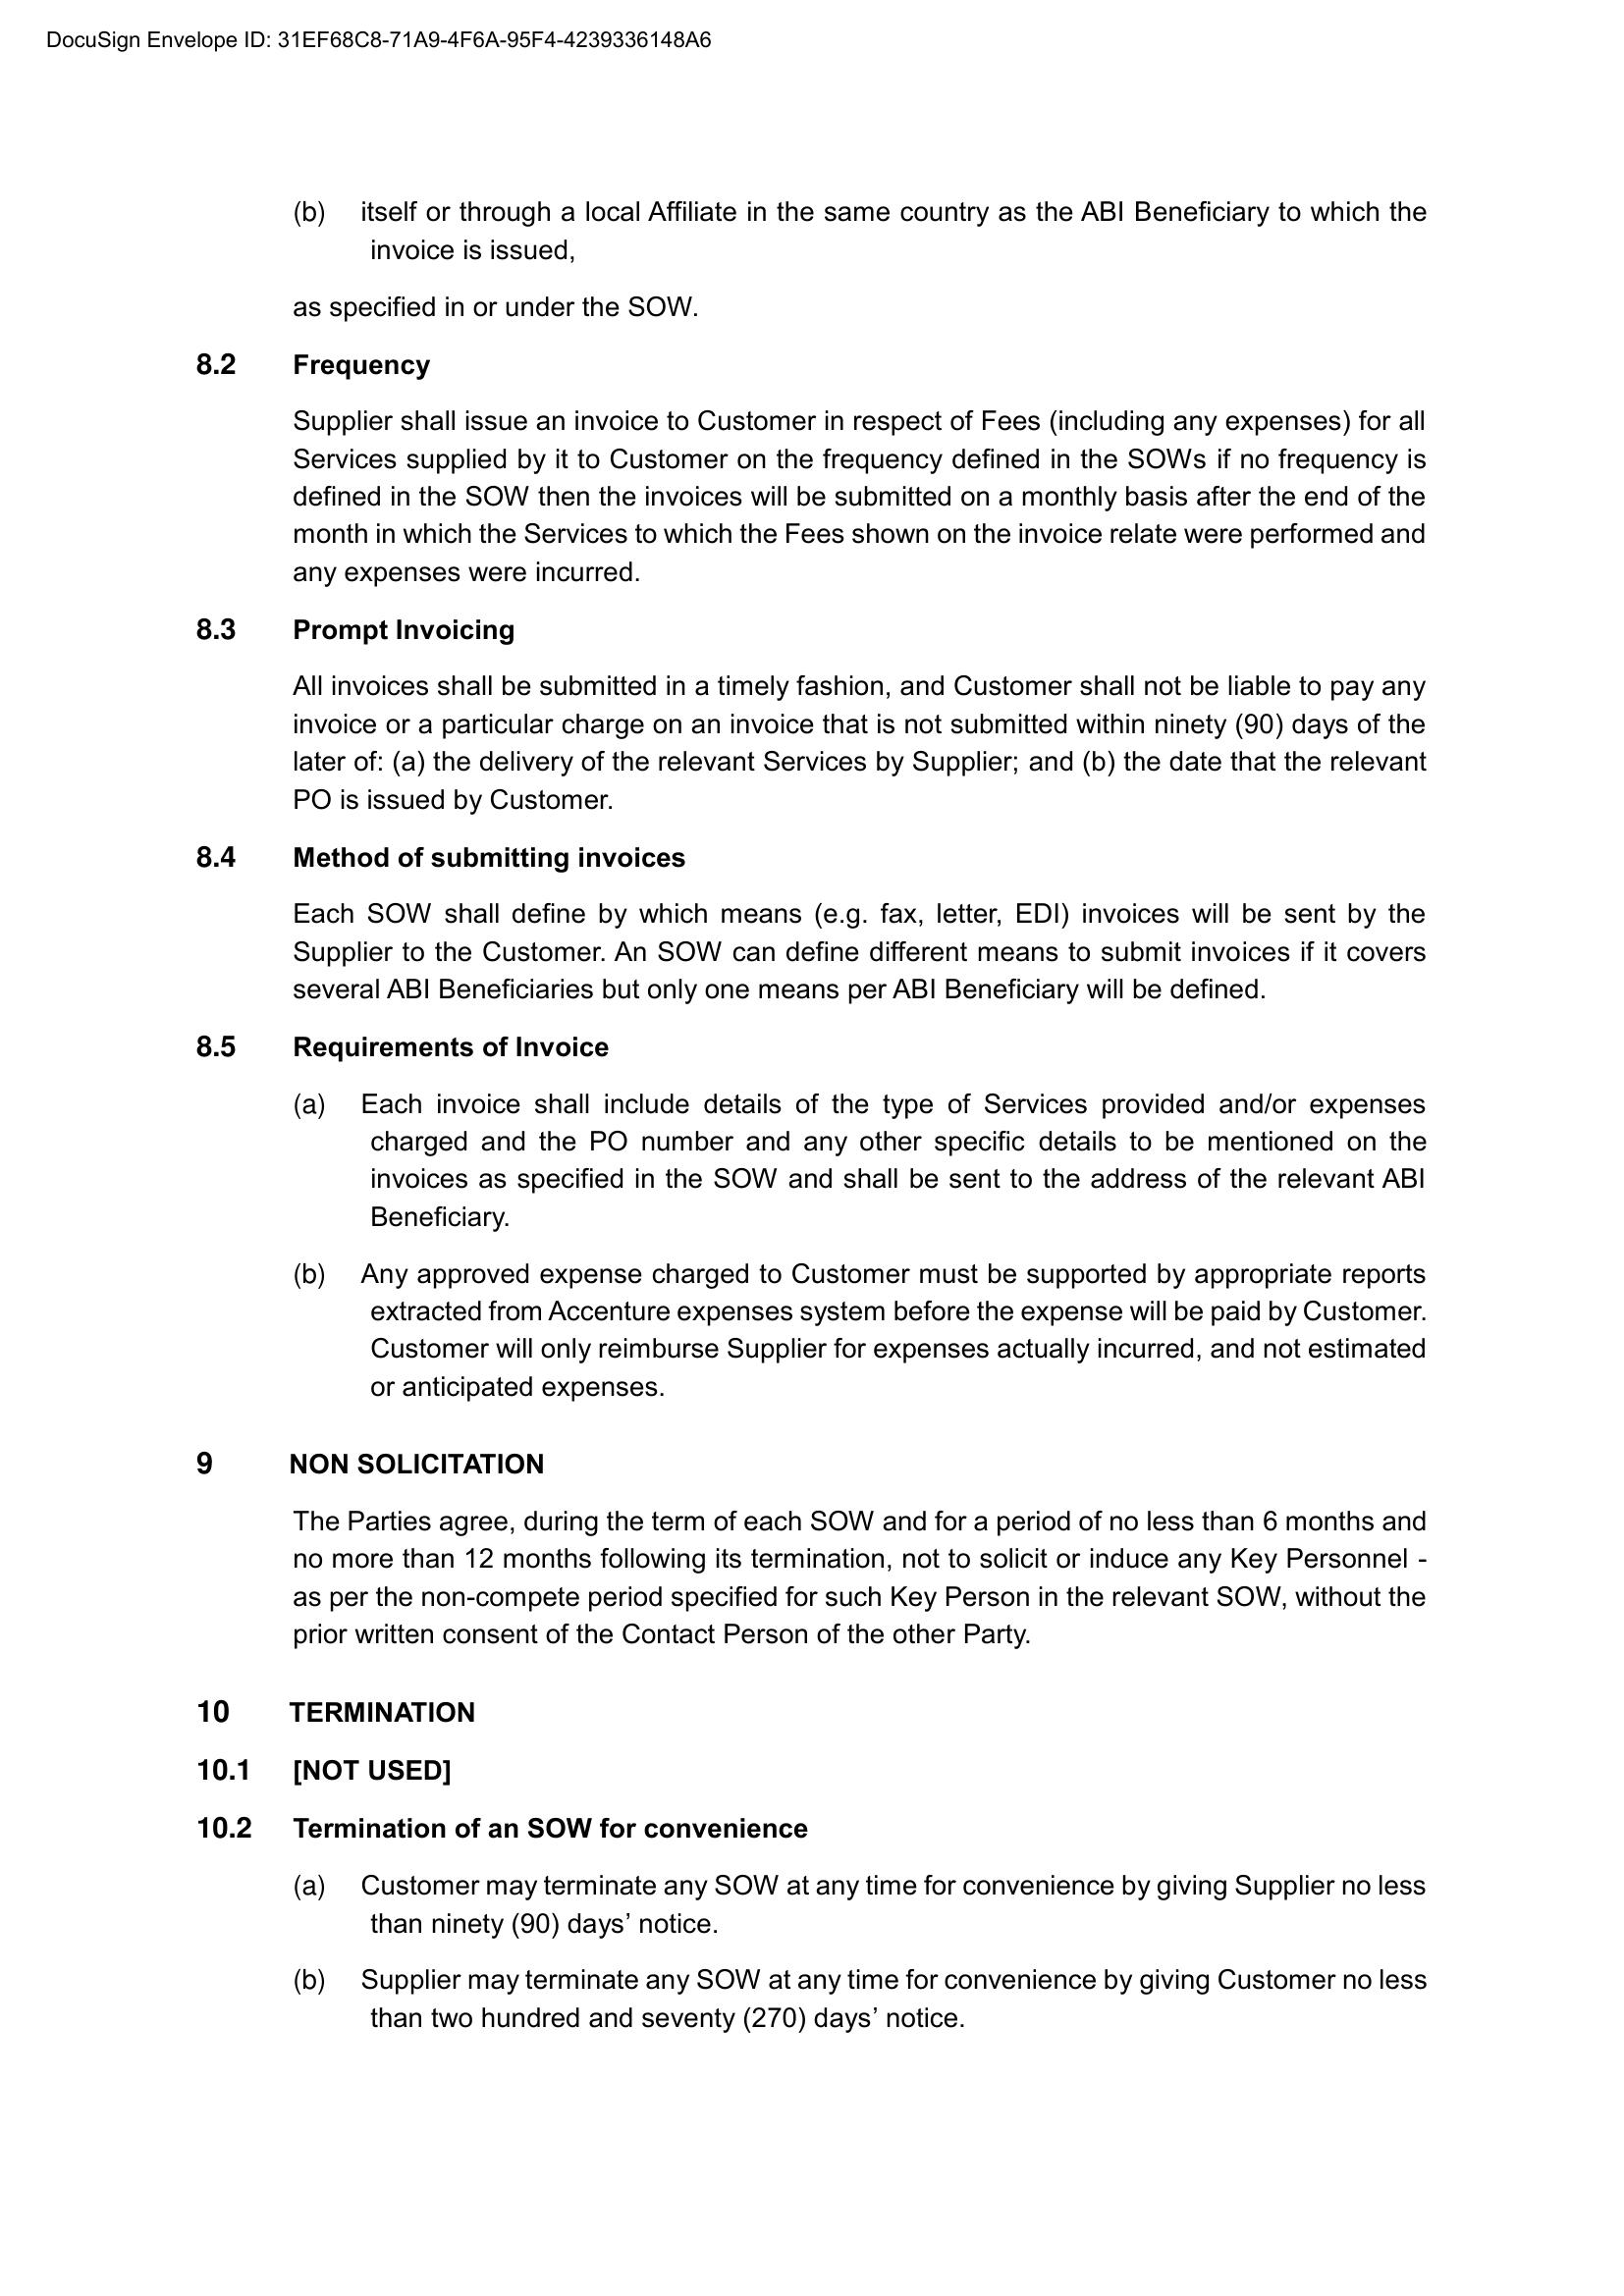

In [66]:
# Preview image for context
display(Image(image_path))

In [67]:
llm_model = get_gpt_model(
    azure_deployment=os.getenv("CHAT_ENGINE_GPT4_DEPLOYMENT_NAME"),
    model_name=os.getenv("CHAT_ENGINE_GPT4_MODEL_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_type=os.getenv("OPENAI_API_TYPE"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    temperature=0.0,
    request_timeout=45,
    max_retries=5,
    seed=1234,
    top_p=0.0001,
)

In [68]:
system_message = (
    "You are an AI assistant specializing in extracting information from images containing three main components: "
    "`text`, `tables`, and `figures`. Your tasks are as follows:\n"
    "* Extract the `text` exactly as it appears in the image.\n"
    "* Extract data from `tables` while preserving the table structure, providing the data in a structured 2D format, "
    "and maintaining hierarchical columns if present and always ensuring the correct structure.\n"
    "* Extract and describe the information from `figures` in plain text format, making it understandable and reproducible "
    "from the extracted data.\n\n"
    "The final output should be in plain text format, containing only the extracted information from the original document."
)

In [69]:
lc_doc = await final_image_extraction_pipeline(image_path, system_message, llm_model)

In [70]:
print(lc_doc.page_content)

(b) itself or through a local Affiliate in the same country as the ABI Beneficiary to which the invoice is issued,

as specified in or under the SOW.

8.2 Frequency

Supplier shall issue an invoice to Customer in respect of Fees (including any expenses) for all Services supplied by it to Customer on the frequency defined in the SOWs if no frequency is defined in the SOW then the invoices will be submitted on a monthly basis after the end of the month in which the Services to which the Fees shown on the invoice relate were performed and any expenses were incurred.

8.3 Prompt Invoicing

All invoices shall be submitted in a timely fashion, and Customer shall not be liable to pay any invoice or a particular charge on an invoice that is not submitted within ninety (90) days of the later of: (a) the delivery of the relevant Services by Supplier; and (b) the date that the relevant PO is issued by Customer.

8.4 Method of submitting invoices

Each SOW shall define by which means (e.g. fax, le

In [71]:
print(lc_doc.metadata)

{'source': 'Accenture__Original__MSA Completely Signed Accenture', 'file_name': 'MSA Completely Signed Accenture', 'file_version': 'Original', 'contractor_name': 'Accenture', 'page_number': 29, 'token_size': 528, 'timestamp': '2024-08-19 10:24:40.729796'}


##### __Parallel Code__

In [72]:
# Apply the patch to allow nested event loops
nest_asyncio.apply()  # only needed for jupyter notebooks remove for production

# Define a semaphore with a limit for concurrent tasks
semaphore = asyncio.Semaphore(
    3
)  # Change 4 to the number of parallel tasks you want to allow


async def process_image_with_semaphore(image_path, system_message, llm_model):
    async with semaphore:
        return await final_image_extraction_pipeline(
            image_path, system_message, llm_model
        )


async def process_images_parallel(image_paths, system_message, llm_model):
    """
    Processes a list of images in parallel using the final_image_extraction_pipeline function
    with a limit on the number of concurrent tasks.

    Args:
    - image_paths (list): List of image file paths.
    - system_message (str): System message to display.
    - llm_model (AzureChatOpenAI): Instance of the AzureChatOpenAI class.

    Returns:
    - list: List of LangChain Document objects containing extracted content and metadata.
    """
    # Create a list of tasks for processing each image
    tasks = [
        process_image_with_semaphore(image_path, system_message, llm_model)
        for image_path in image_paths
    ]

    # Run all tasks in parallel and gather the results
    documents = await asyncio.gather(*tasks, return_exceptions=True)

    return documents

In [73]:
lc_doc_ls = await process_images_parallel(docs_ls, system_message, llm_model)

In [76]:
lc_doc_ls = [doc for doc in lc_doc_ls if isinstance(doc, Document)]

In [77]:
len(lc_doc_ls)

98

In [74]:
# print(lc_doc_ls[77].page_content)

In [75]:
# print(lc_doc_ls[77].metadata)

In [36]:
os.makedirs("extracted_docs/Accenture", exist_ok=True)
pickle.dump(lc_doc_ls, open("extracted_docs/Accenture/extracted_docs.pkl", "wb"))

##### Easy pdf

In [1]:
loader = PyPDFium2Loader(data_path)
docs = loader.load()
print(len(docs))


# calculate tiktoken token count
def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens
# num_tokens_from_string("tiktoken is great!")


async def get_lc_document_from_response(docs, data_path):
    """
    Creates a LangChain Document object from the LC pdf parser response.

    Args:
        docs: list of LangChain Document objects containing extracted content and metadata.
        data_path: str, path to the pdf file.

    Returns:
        doc: list of LangChain Document objects containing extracted content and metadata.

    """
    curr_time = datetime.now()
    whole_pdf_name = data_path.split("/")[-2] + "__" + data_path.split("/")[-1]
    file_name = data_path.split("/")[-1].split(".")[0]
    entity_name = data_path.split("/")[-2]

    # langchain document object , restructing the response

    doc = [
        Document(
            page_content=doc.page_content,
            metadata={
                "source": whole_pdf_name,
                "file_name": file_name,
                "page_number": doc.metadata["page"],
                "token_size": num_tokens_from_string(doc.page_content),
                "timestamp": str(curr_time),
                "entity_name": entity_name,
            },
        )
        for doc in docs
    ]

    return doc

NameError: name 'PyPDFium2Loader' is not defined